# MiloR differential abundance testing

In [1]:
# Load packages
suppressPackageStartupMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(SingleCellExperiment)
    library(scater)
    library(scran)
    library(edgeR)
    library(ggrastr)
    library(Seurat)
    library(miloR)
})

here::i_am("MiloR/01_Milo_analysis_manual.ipynb")

# Load default settings
source(here::here("settings.R"))
source(here::here("utils.R"))
BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

set.seed(1234)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/01_Eomes_RNA/code



In [2]:
io$basedir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/01_Eomes_RNA"

In [3]:
args = list()
args$sce = io$rna.sce
args$metadata = '/rds/project/rds-SDzz0CATGms/users/bt392/01_Eomes_RNA/results/rna/mapping/manual/metadata_mapping_updated.txt.gz'
args$remove_ExE_cells = TRUE
args$batch_correction = "tdTom"
args$vars_to_regress = c('nFeature_RNA', 'nCount_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA')
args$features = 4000
args$npcs = 40
args$n_neighbors = 20
args$min_dist = 0.4
args$prop = 0.1
args$seed = 12345
args$outdir = paste0(io$basedir,"/results/rna/MiloR/manual/")
dir.create(args$outdir, recursive=TRUE, showWarnings = FALSE)

# Dimensionality reduction

In [15]:
###############
## Load data ##
###############

# Load metadata
sample_metadata = fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_call==FALSE] %>%
   .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)]

if (args$remove_ExE_cells) {
  print("Removing ExE cells...")
  sample_metadata = sample_metadata %>%
    .[!celltype.mapped_mnn%in%c("Visceral_endoderm","ExE_endoderm","ExE_ectoderm","Parietal_endoderm")]
}

# Load RNA expression data as SingleCellExperiment object
sce <- load_SingleCellExperiment(args$sce, cells=sample_metadata$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce) <- sample_metadata %>% tibble::column_to_rownames("cell") %>% DataFrame

[1] "Removing ExE cells..."


In [16]:
##############################
## Dimensionality Reduction ##
##############################

if (args$batch_correction %in% c('tdTom')) {
     source(here::here("mapping/run/mnn/mapping_functions.R"))
     library(batchelor)
   }

 if (length(args$vars_to_regress)>0) {
  stopifnot(args$vars_to_regress%in%colnames(sample_metadata))
 }

## Feature selection 

# Find HVGs - detection on WT samples only
# Get gene metadata
gene_metadata <- fread(io$gene_metadata) %>% .[,c("chr","ens_id","symbol", "description")] %>%
  .[symbol!="" & ens_id%in%rownames(sce)] %>%
  .[!duplicated(symbol)]

# Imprinted genes
imprint = gene_metadata[c(grep('maternally', gene_metadata$description),
                       grep('paternally', gene_metadata$description)), symbol]
# Other imprinted genes: 
#- Nnat (https://www.genecards.org/cgi-bin/carddisp.pl?gene=NNAT)
#- Grb10 (https://www.genecards.org/cgi-bin/carddisp.pl?gene=GRB10)

genes_keep = rownames(sce)
genes_keep <- genes_keep[grep("^Rik|Rik$|^mt-|^Rps|^Rpl|^Gm",genes_keep,invert=T)] # filter out non-informative genes
genes_keep <- genes_keep[grep("^Hbb|^Hba",genes_keep,invert=T)] # test removing Haem genes 
genes_keep <- genes_keep[!genes_keep %in% c(imprint, 'Grb10', 'Nnat')] # remove imprinted genes
genes_keep <- genes_keep[!genes_keep %in% c("Xist", "Tsix")] # remove Xist & Tsix
genes_keep <- genes_keep[!genes_keep == "tomato-td"] # remove tomato itself
genes_keep <- genes_keep[!genes_keep %in% gene_metadata[chr=="chrY",symbol]] # no genes on y-chr 

sce_wt = sce[genes_keep, sample_metadata[tdTom==FALSE, cell]]
# Find variable genes using Seurat
hvgs = VariableFeatures(FindVariableFeatures(as.Seurat(sce_wt), nfeatures = args$features))

sce_filt <- sce[hvgs,]

In [17]:
## Regress out covariates 
 if (length(args$vars_to_regress)>0) {
   print(sprintf("Regressing out variables: %s", paste(args$vars_to_regress,collapse=" ")))
   logcounts(sce_filt) <- RegressOutMatrix(
     mtx = logcounts(sce_filt), 
     covariates = colData(sce_filt)[,args$vars_to_regress,drop=F]
   )
 }

[1] "Regressing out variables: nFeature_RNA nCount_RNA mitochondrial_percent_RNA ribosomal_percent_RNA"


In [18]:
# PCA and batch correction
if (args$batch_correction=='tdTom') {
    print('batch correcting by tdTom')
    pca <- multiBatchPCA(sce_filt, batch = colData(sce_filt)[[args$batch_correction]], d = args$npcs)
    pca.corrected <- reducedMNN(pca)$corrected
    colnames(pca.corrected) <- paste0("PC",1:ncol(pca.corrected))
    pca.corrected = pca.corrected[match(colnames(sce_filt), rownames(pca.corrected)),]
    reducedDim(sce_filt, "PCA") <- pca.corrected
 } else {
    print('PCA without batch correction')
    sce_filt <- runPCA(sce_filt, ncomponents = args$npcs, ntop=args$features)  
 }

[1] "batch correcting by tdTom"


In [19]:
 pca.dt <- reducedDim(sce_filt,"PCA") %>% round(3) %>% as.data.table(keep.rownames = T) %>% setnames("rn","cell")


In [20]:
fwrite(pca.dt, file.path(args$outdir, 'PCA.txt.gz'))

In [21]:
## UMAP
set.seed(args$seed)
sce_filt <- runUMAP(sce_filt, dimred="PCA", n_neighbors = args$n_neighbors, min_dist = args$min_dist)

# Fetch UMAP coordinates
umap.dt <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
  .[,cell:=colnames(sce_filt)] %>%
  setnames(c("UMAP1","UMAP2","cell"))

In [22]:
fwrite(umap.dt, file.path(args$outdir, 'UMAP.txt.gz'))

In [23]:
# plotting
to.plot <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
    .[,cell:=colnames(sce_filt)] %>%
    merge(sample_metadata, by="cell")

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


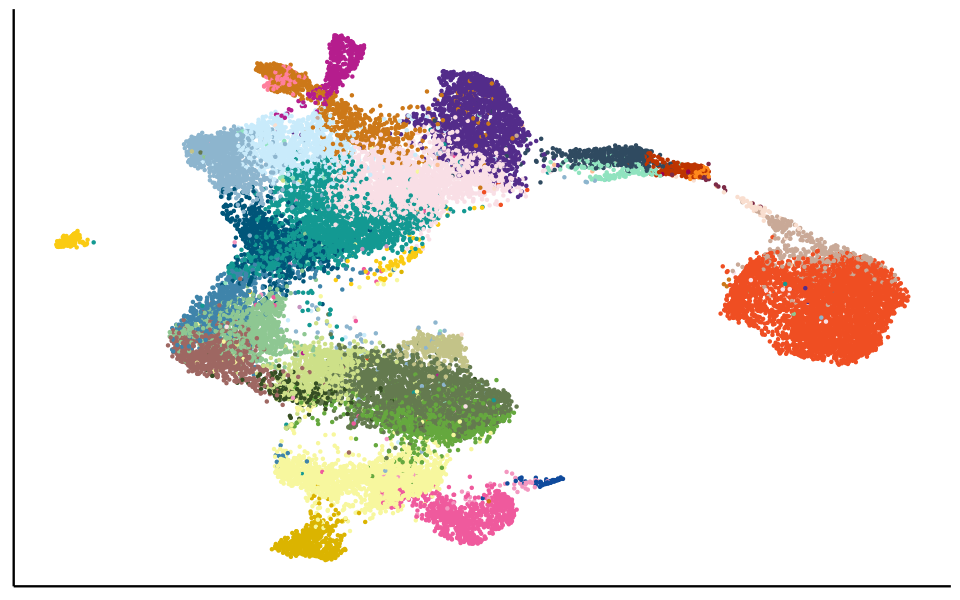

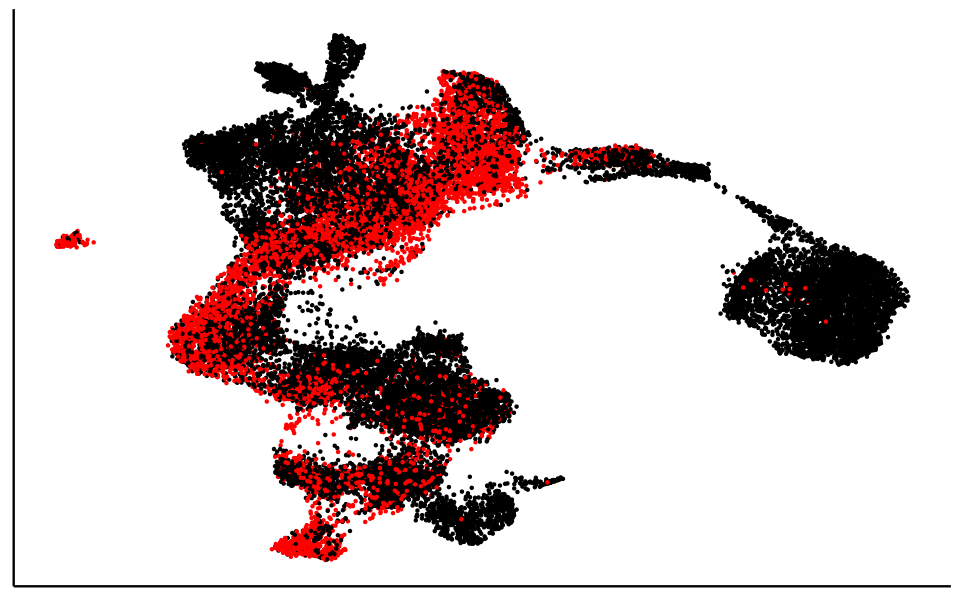

In [24]:
ggplot(to.plot, aes_string(x="V1", y="V2", col='celltype_updated')) +
    geom_point(size=0.2) +
    theme_classic() +
    scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme(
        legend.position="none",
        legend.title=element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    )

ggplot(to.plot, aes_string(x="V1", y="V2", col='tdTom')) +
    geom_point(size=0.2) +
    theme_classic() +
    scale_color_manual(values=opts$tdTom.color) +
    theme(
        legend.position="none",
        legend.title=element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    )

In [89]:
unique(to.plot$celltype_updated)

[1] "Forebrain_Midbrain_Hindbrain"   "Intermediate_mesoderm"         
 [3] "Allantois"                      "Surface_ectoderm"              
 [5] "Caudal_Mesoderm"                "Somitic_mesoderm"              
 [7] "Lateral_plate_mesoderm"         "Caudal_epiblast"               
 [9] "Spinal_cord"                    "Amniotic_ectoderm"             
[11] "PGC"                            "Paraxial_mesoderm"             
[13] "Rostral_neurectoderm"           "NMP"                           
[15] "Pharyngeal_mesoderm"            "Caudal_neurectoderm"           
[17] "Mesenchyme"                     "YS_endothelium"                
[19] "Erythroid"                      "Venous_endothelium"            
[21] "Embryo_proper_endothelium"      "Allantois_endothelium"         
[23] "Blood_progenitors_1"            "Gut"                           
[25] "Cardiomyocytes"                 "Blood_progenitors_2"           
[27] "Notochord"                      "YS_mesothelium"                
[29] "Haematoendothelial_progenitors" "Neural_crest"                  
[31] "Def._endoderm"                  "Endocardium"                   
[33] "EMP"                            "Primitive_Streak"              
[35] "Nascent_mesoderm"               "Epiblast"                      
[37] "Anterior_Primitive_Streak"      "Non-neural_ectoderm"

# MiloR

In [112]:
# Add PCA to SCE object
reducedDim(sce,"PCA") = reducedDim(sce_filt,"PCA")

# Add UMAP to SCE object
reducedDim(sce,"UMAP") = reducedDim(sce_filt,"UMAP")

# Add UMAP of Atlas to SCE object
umap.dt <- sample_metadata %>%
    .[,c("cell","umapX","umapY")]
umap = umap.dt[match(colnames(sce), cell)] %>% tibble::column_to_rownames("cell") %>% as.matrix
reducedDim(sce,"UMAP_atlas") = umap

In [113]:
# Milo arguments
args$prop = 0.1
args$n_neighbors = 20 # smaller --> smaller Nhoods --> higher resolution, but worse statistics


Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim



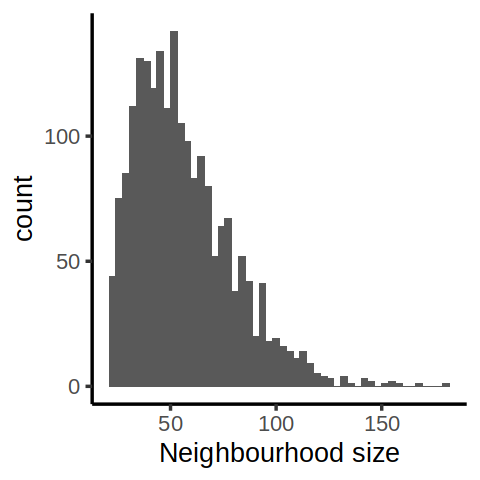

In [114]:
# create object
Milo_sce <- Milo(sce)

colData(Milo_sce)$sample_ko = paste0(colData(Milo_sce)$sample, '_',  colData(Milo_sce)$tdTom)

# Build graph
Milo_sce <- buildGraph(Milo_sce, 
                       k = args$n_neighbors, 
                       d = args$npcs, 
                       reduced.dim = "PCA")

# Identify neighbourhoods from NN-cells
# lower prop for larger datasets
Milo_sce <- makeNhoods(Milo_sce, 
                       prop = args$prop, 
                       k = args$n_neighbors, 
                       d = args$npcs, 
                       refined = TRUE, 
                       reduced_dims = "PCA")

options(repr.plot.width = 7, repr.plot.height=6)
plotNhoodSizeHist(Milo_sce)

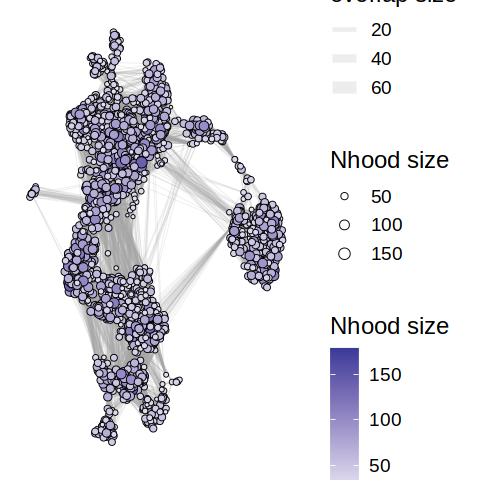

In [115]:
# Build neighbourhood graph
Milo_sce <- buildNhoodGraph(Milo_sce)
plotNhoodGraph(
  Milo_sce,
  layout = "UMAP")

In [116]:
Milo_sce

class: Milo 
dim: 29453 27845 
metadata(0):
assays(2): counts logcounts
rownames(29453): Xkr4 Gm1992 ... CAAA01147332.1 tomato-td
rowData names(0):
colnames(27845): SLX-20795_SITTH10_HKTG2DRXY#GTTCATTTCACCCTGT-1
  SLX-20795_SITTG11_HKTG2DRXY#ATAGAGACATATGGCT-1 ...
  SLX-20795_SITTH10_HKTG2DRXY#GTCAAACCACCTGCTT-1
  SLX-20795_SITTB11_HKTG2DRXY#AAAGGATAGGTACAAT-1
colData names(25): closest.cell_mnn sample ... pool sample_ko
reducedDimNames(3): PCA UMAP UMAP_atlas
mainExpName: RNA
altExpNames(0):
nhoods dimensions(2): 27845 2046
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 2046
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 2046 2046

In [117]:
# count cells of different samples per neighbourhood
Milo_sce <- countCells(Milo_sce, meta.data = colData(Milo_sce),  samples = 'sample_ko')

# Calculate Neighbourhood Distances (most time consuming step)
Milo_sce <- calcNhoodDistance(Milo_sce, d=args$npcs, reduced.dim = "PCA")

# Build neighbourhood graph
#Milo_sce <- buildNhoodGraph(Milo_sce)

Checking meta.data validity

Counting cells in neighbourhoods



In [ ]:
saveRDS(Milo_sce, file.path(args$outdir, 'Milo_sce.rds'))

In [118]:
# Embryo design table
embryo_design <- data.frame(colData(Milo_sce))[,c("sample_ko", "sample", 'tdTom', 'pool')]

embryo_design <- distinct(embryo_design)
rownames(embryo_design) <- embryo_design$sample_ko

# Test differential abundance per hood
da_results <- testNhoods(Milo_sce, design = ~ as.factor(pool) + tdTom, design.df = embryo_design, reduced.dim="PCA")

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [119]:
p1 = ggplot(da_results, aes(PValue)) + 
    geom_histogram(bins=50) + 
    theme_bw()

p2 = ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
    geom_point() +
    geom_hline(yintercept = 1) + ## Mark significance threshold (10% FDR)
    theme_bw()


## Plot single-cell UMAP
p3 = plotReducedDim(Milo_sce, dimred = "UMAP", colour_by="tdTom_corr", text_by = "celltype.mapped_mnn", 
                          text_size = 3, point_size=0.3, text_colour = "grey30") +
    scale_color_manual(values=opts$tdTom.color, name = 'tdTom') + 
    theme_void() + 
    theme(legend.position='right') +
    guides(fill="none")

## Plot neighbourhood graph
p4 = plotNhoodGraphDA(Milo_sce, da_results, layout="UMAP",alpha=0.05) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


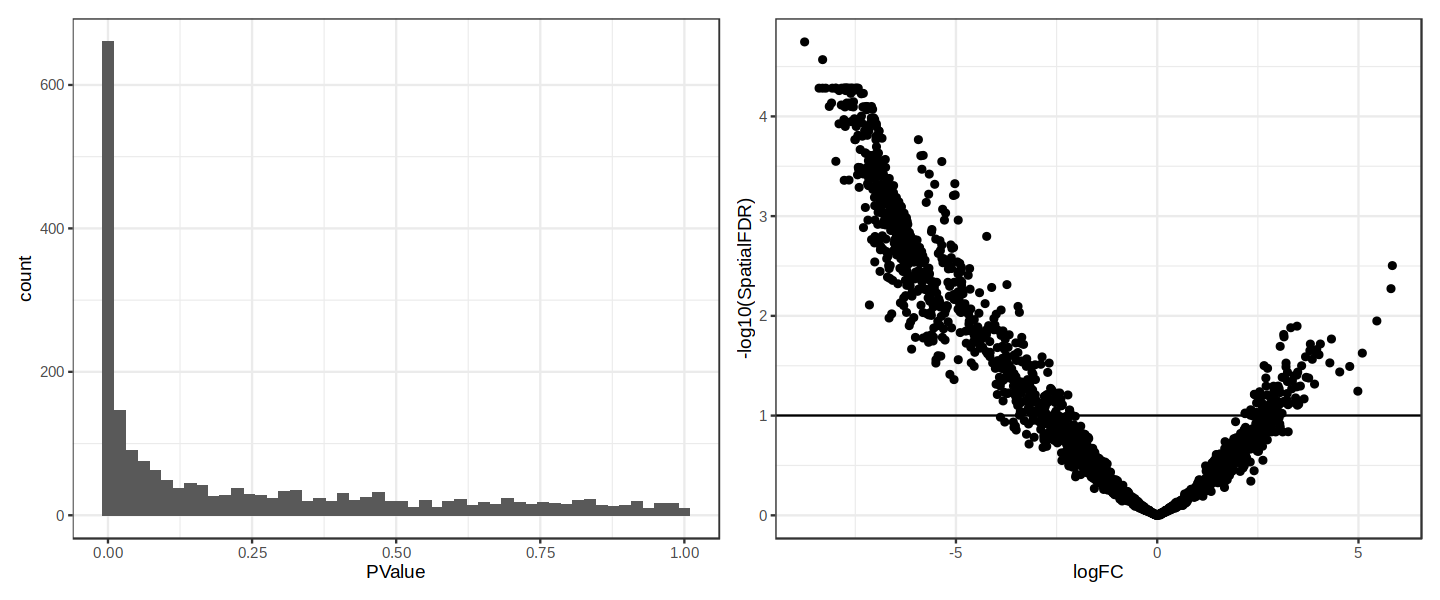

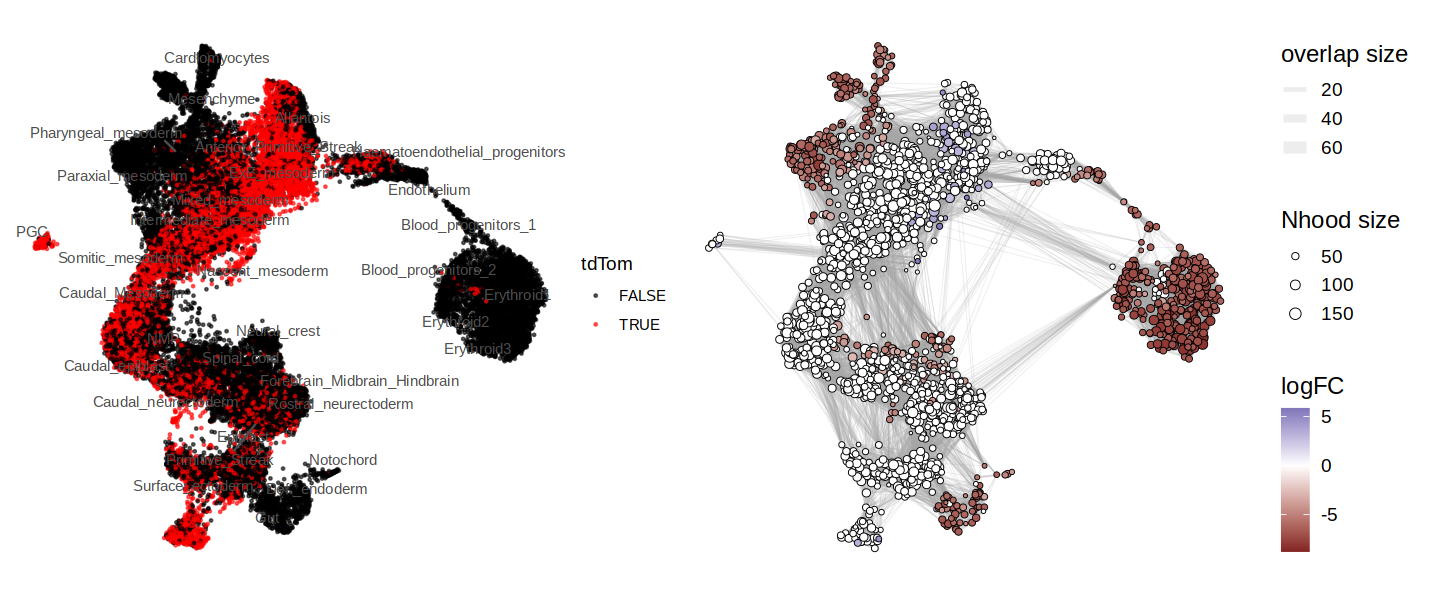

In [120]:
options(repr.plot.width = 12, repr.plot.height=5)

p1 + p2
p3 + p4 

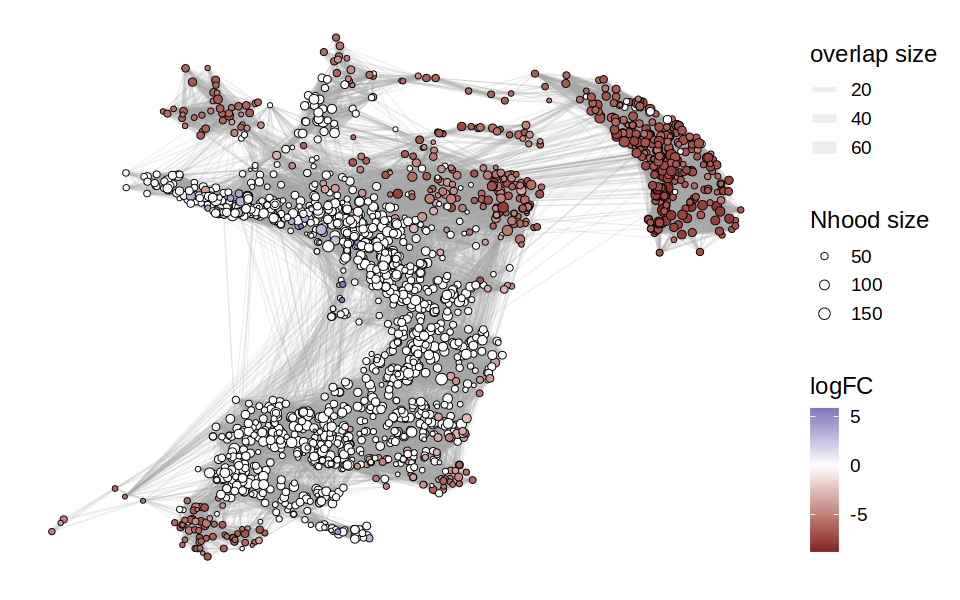

In [121]:
options(repr.plot.width = 8, repr.plot.height=5)
plotNhoodGraphDA(Milo_sce, da_results, layout="UMAP_atlas",alpha=0.05) 

In [122]:
# Find Neighbourhood groups
#da_results <- groupNhoods(Milo_sce, da_results, max.lfc.delta = 0.5, overlap = 20)

# Annotate hoods by celltype
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype.mapped_mnn")
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype_extended.mapped_mnn")
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype_updated")

# Annotate 'mixed' hoods when there is not one main celltype
da_results$celltype.mapped_mnn <- ifelse(da_results$celltype.mapped_mnn_fraction < 0.4, "Mixed", da_results$celltype.mapped_mnn)
da_results$celltype_extended.mapped_mnn <- ifelse(da_results$celltype.mapped_mnn_fraction < 0.4, "Mixed", da_results$celltype_extended.mapped_mnn)
da_results$celltype_updated <- ifelse(da_results$celltype_updated_fraction < 0.4, "Mixed", da_results$celltype_updated)

Converting celltype.mapped_mnn to factor...

Converting celltype_extended.mapped_mnn to factor...

Converting celltype_updated to factor...



In [ ]:
fwrite(da_results, file.path(args$outdir, 'da_results.txt.gz'))

In [4]:
da_results = fread(file.path(args$outdir, 'da_results.txt.gz'))

In [5]:
summary(is.na(da_results$celltype_updated))

   Mode   FALSE 
logical    2046 

In [6]:
celltype2germlayer = c(
    'Amniotic_ectoderm' = 'ectoderm', 
    'Surface_ectoderm' = 'ectoderm', 
    'Caudal_neurectoderm' = 'ectoderm',
    'Rostral_neurectoderm' = 'ectoderm', 
    'Spinal_cord' = 'ectoderm', 
    'NMP' = 'ectoderm', 
    'Forebrain_Midbrain_Hindbrain' = 'ectoderm', 
    'Neural_crest' = 'ectoderm', 

    'Notochord' = 'endoderm', 
    'Def._endoderm' = 'endoderm', 
    'Gut' = 'endoderm', 

    'PGC' = 'other', 
    'Caudal_epiblast' = 'other', 
    'Mixed' = 'other', 

    'Intermediate_mesoderm' = 'mesoderm', 
    'Nascent_mesoderm' = 'mesoderm',
    'Lateral_plate_mesoderm' = 'mesoderm', 
    'Allantois' = 'mesoderm', 
    'Somitic_mesoderm' = 'mesoderm', 
    'Caudal_Mesoderm' = 'mesoderm', 
    'Mesenchyme' = 'mesoderm', 
    'Pharyngeal_mesoderm' = 'mesoderm', 
    'Paraxial_mesoderm' = 'mesoderm', 
    'Cardiomyocytes' = 'mesoderm', 
    'YS_mesothelium' = 'mesoderm', 
    'Venous_endothelium' = 'mesoderm', 
    'Embryo_proper_endothelium' = 'mesoderm', 
    'Allantois_endothelium' = 'mesoderm', 
    'YS_endothelium' = 'mesoderm', 
    'Blood_progenitors_1' = 'mesoderm', 
    'Blood_progenitors_2' = 'mesoderm',
    'Erythroid' = 'mesoderm'
)

In [7]:
da_results.plot = as.data.table(da_results) %>% copy() %>%
    .[,color := ifelse(SpatialFDR < 0.05, logFC, 0)] %>% .[order(abs(color))] %>% 
    .[,germ_layer := str_to_title(celltype2germlayer[celltype_updated])] %>%
    .[, celltype_updated := factor( gsub('_', ' ', celltype_updated), levels =  gsub('_', ' ', names(celltype2germlayer)))]

In [9]:
head(da_results.plot)

logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,celltype.mapped_mnn,celltype.mapped_mnn_fraction,celltype_extended.mapped_mnn,celltype_extended.mapped_mnn_fraction,celltype_updated,celltype_updated_fraction,color,germ_layer
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
-1.4467697,10.058998,2.02575594,0.15470278,0.26948090,1,0.26802960,Spinal_cord,0.8255814,Dorsal_spinal_cord_progenitors,0.4883721,Spinal cord,0.8255814,0,Ectoderm
-0.3171983,9.426329,0.07639222,0.78225675,0.85466072,2,0.85477899,Rostral_neurectoderm,0.4600000,Ectoderm,0.9400000,Rostral neurectoderm,0.4600000,0,Ectoderm
-1.1048727,9.506563,0.79585695,0.37236994,0.51442869,3,0.51369447,Surface_ectoderm,0.9821429,Pharyngeal_endoderm,0.5714286,Surface ectoderm,0.9821429,0,Ectoderm
-0.2522203,9.238211,0.04044208,0.84062535,0.89253735,8,0.89224571,NMP,0.8571429,NMPs,0.4761905,NMP,0.8571429,0,Ectoderm
1.3626932,10.511434,1.81665768,0.17776138,0.29983494,9,0.29827043,Intermediate_mesoderm,0.9444444,Intermediate_mesoderm,0.6875000,Intermediate mesoderm,0.9513889,0,Mesoderm
-2.9158132,9.350824,4.58411036,0.03230899,0.08110944,11,0.07892627,NMP,0.9411765,NMPs_Mesoderm-biased,0.6666667,NMP,0.9411765,0,Ectoderm


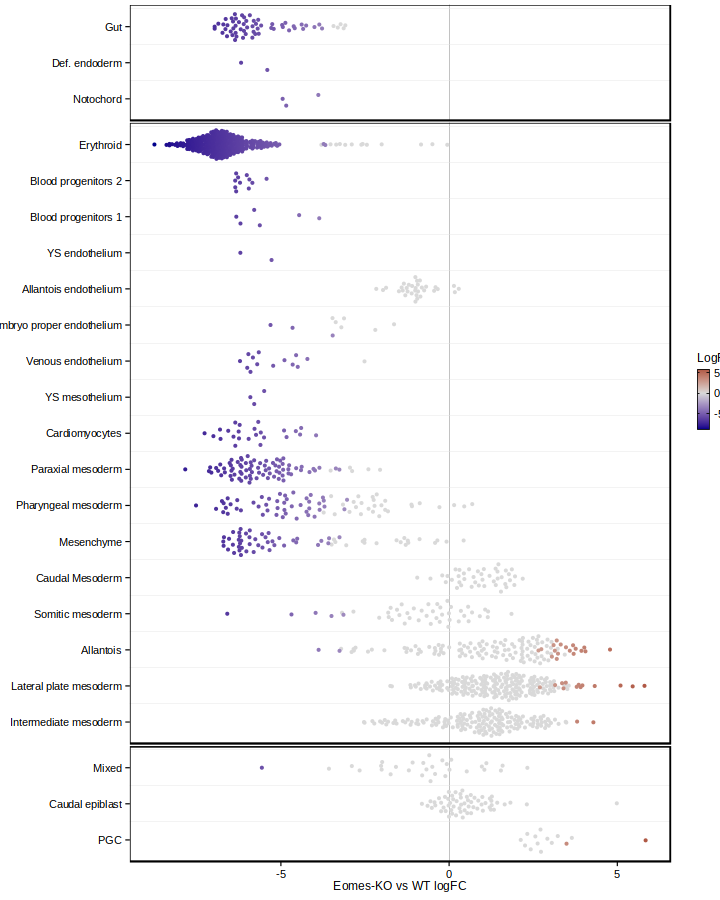

In [12]:
options(repr.plot.width = 6, repr.plot.height=7.5)
p_main = ggplot(da_results.plot[germ_layer != 'Ectoderm'], aes(logFC,celltype_updated, color=color)) + 
    geom_vline(xintercept = 0, color = 'grey50', linewidth = 0.1) +
    ggbeeswarm::geom_quasirandom(size = 0.1) + 
    geom_hline(yintercept=seq(1.5, 20, 1), color = 'grey90', linewidth = 0.1) + 
    scale_color_gradient2(low='darkblue', mid='grey85', high='darkred', name = 'LogFC') + 
    facet_grid(rows = vars(germ_layer), scales='free', space='free') + 
    guides(colour = guide_colourbar(
         barwidth = 0.5, barheight = 2.5,
        frame.colour = "black", 
        ticks.colour = "black"
    )) + 
    # ggtitle('Differential Abundance') + 
    xlab('Eomes-KO vs WT logFC') + 
    theme_bw() + 
    theme(axis.text = element_text(size=6, color='black'),
          axis.title.y = element_blank(),
          axis.title.x = element_text(size=7, color='black', vjust = 1.5),
          axis.ticks = element_line(linewidth=0.25, color = 'black'),
          legend.text = element_text(size=6, color='black'),
          legend.title = element_text(size=7, color='black'),
          plot.title = element_text(size=8, color='black', hjust = 0.5, vjust = -1),
          panel.border = element_rect(color='black', linewidth=0.5),
          panel.spacing = unit(0.5, "mm"),
          legend.position = c(1.05, 0.55), # Position legend outside the plot (right and center vertically)
          legend.justification = c("left", "center"), # Justify legend to the center vertically and to the left horizontally
          legend.box.margin = margin(0, 0, 0, 0), # Adjust the margins around the legend box
          legend.margin = margin(0, 0, 0, 0), # Adjust the margins inside the legend box
          plot.margin = margin(3,30,3,3),
          panel.grid = element_blank(), 
          # legend.position='right',
          strip.background=element_blank(),
          strip.text.y = element_blank()) #_text(size=15, color='black', angle=0, hjust=0))
p_main
ggsave(file.path(io$basedir, 'figures/differential_abundance.pdf'), 
       plot = p_main, 
       width = 70, height = 67, units = "mm")

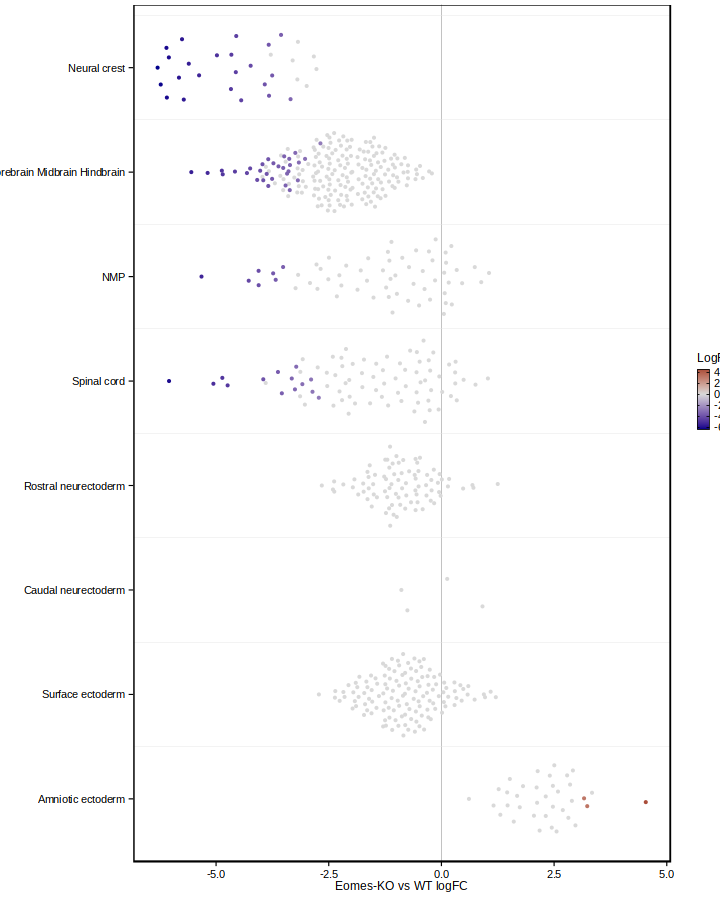

In [14]:
options(repr.plot.width = 6, repr.plot.height=7.5)
p_supp = ggplot(da_results.plot[germ_layer == 'Ectoderm'], aes(logFC,celltype_updated, color=color)) + 
    geom_vline(xintercept = 0, color = 'grey50', linewidth = 0.1) +
    ggbeeswarm::geom_quasirandom(size = 0.1) + 
    geom_hline(yintercept=seq(1.5, 20, 1), color = 'grey90', linewidth = 0.1) + 
    scale_color_gradient2(low='darkblue', mid='grey85', high='darkred', name = 'LogFC') + 
    facet_grid(rows = vars(germ_layer), scales='free', space='free') + 
    guides(colour = guide_colourbar(
         barwidth = 0.5, barheight = 2.5,
        frame.colour = "black", 
        ticks.colour = "black"
    )) + 
    # ggtitle('Differential Abundance') + 
    xlab('Eomes-KO vs WT logFC') + 
    theme_bw() + 
    theme(axis.text = element_text(size=6, color='black'),
          axis.title.y = element_blank(),
          axis.title.x = element_text(size=7, color='black', vjust = 1.5),
          axis.ticks = element_line(linewidth=0.25, color = 'black'),
          legend.text = element_text(size=6, color='black'),
          legend.title = element_text(size=7, color='black'),
          plot.title = element_text(size=8, color='black', hjust = 0.5, vjust = -1),
          panel.border = element_rect(color='black', linewidth=0.5),
          panel.spacing = unit(0.5, "mm"),
          legend.position = c(1.05, 0.55), # Position legend outside the plot (right and center vertically)
          legend.justification = c("left", "center"), # Justify legend to the center vertically and to the left horizontally
          legend.box.margin = margin(0, 0, 0, 0), # Adjust the margins around the legend box
          legend.margin = margin(0, 0, 0, 0), # Adjust the margins inside the legend box
          plot.margin = margin(3,30,3,3),
          panel.grid = element_blank(), 
          # legend.position='right',
          strip.background=element_blank(),
          strip.text.y = element_blank()) #_text(size=15, color='black', angle=0, hjust=0))
p_supp
ggsave(file.path(io$basedir, 'figures/differential_abundance_supp.pdf'), 
       plot = p_supp, 
       width = 70, height = 40, units = "mm")

### Searching for differential genes within the allantois based on differential nhoods

In [249]:
# Functions
# Plotting function
gg_volcano_plot <- function(top_genes=20, xlim=5, ylim=40, label_groups = NULL) {
  to.plot = de.results
  negative_hits <- to.plot[sig==TRUE & logFC<0,gene]
  positive_hits <- to.plot[sig==TRUE & logFC>0,gene]
  all <- nrow(to.plot[!is.na(sig)])
  to.plot = to.plot[,logFC_plot:=ifelse(logFC<=-xlim, -xlim, ifelse(logFC>=xlim, xlim, logFC))] %>%
               .[,log10_padj_fdr:=ifelse(-log10(padj_fdr)>=ylim, ylim, -log10(padj_fdr))]
  
  to.plot <- to.plot[!is.na(logFC) & !is.na(padj_fdr)] %>% .[order(-abs(logFC))]
  label_genes = c(head(to.plot[sig==T & logFC<=0, gene],n=top_genes), head(to.plot[sig==T & logFC>=0, gene],n=top_genes))
  
  p <- ggplot(to.plot, aes(x=logFC_plot, y=log10_padj_fdr)) +
    labs(x="Log fold change", y=expression(paste("-log"[10],"(q.value)"))) +
    ggrastr::geom_point_rast(aes(color=sig, size=sig)) +
    # geom_hline(yintercept = -log10(opts$threshold_fdr), color="blue") +
    geom_segment(aes(x=0, xend=0, y=0, yend=ylim*1.05), color="orange", size=0.5) +
    scale_color_manual(values=c("black","red")) +
    scale_size_manual(values=c(0.5,1)) +
    scale_x_continuous(limits=c(-xlim,xlim)) +
    scale_y_continuous(limits=c(0,ylim*1.16)) +
    annotate("text", x=0, y=ylim*1.1, size=6, label=sprintf("(%d)", all)) +
    annotate("text", x=-xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (-)",length(negative_hits))) +
    annotate("text", x=xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (+)",length(positive_hits))) +
    ggrepel::geom_text_repel(data=to.plot[gene %in% label_genes],
                                    aes(x=logFC_plot, y=log10_padj_fdr, label=gene), 
                                     max.overlaps=Inf, 
                                     box.padding = 0.5,
                                     bg.color='white', 
                                     bg.r = 0.1,
                                     size=5) +
    theme_classic() +
    theme(
       axis.text = element_text(color='black'),
      # axis.title = element_text(size=rel(1.0), color='black'),
      text=element_text(size=15),
      legend.position="none"
    ) 

    
    
  if (length(label_groups)>0) {
    p <- p +
      annotate("text", x=-4, y=0, size=4, label=sprintf("Up in %s",label_groups[2])) +
      annotate("text", x=4, y=0, size=4, label=sprintf("Up in %s",label_groups[1]))
  }
  
  return(p)
}

In [5]:
Milo_sce = readRDS(file.path(args$outdir, 'Milo_sce.rds'))
da_results = fread(file.path(args$outdir, 'da_results.txt.gz'))

In [228]:
da_results$NhoodGroup <- ifelse(da_results$celltype_updated != 'Allantois', 'Other', 
                                ifelse(da_results$logFC > 2, 'Up', 'Not_Up'))
#da_nhood_markers <- findNhoodGroupMarkers(embryo_milo, da_results, subset.row = rownames(embryo_milo)[1:10])

In [229]:
da_allantois = da_results[celltype_updated == 'Allantois']
#Milo_allantois =  Milo_sce[,Milo_sce$tdTom==FALSE]

In [230]:
test = lapply(c('Up', 'Not_Up'),function(x){
    tmp = nhoods(Milo_sce)[Milo_sce$tdTom==FALSE,]
    cells = tmp[,da_allantois[da_allantois$NhoodGroup == x, Nhood]]
    cell_sums = rowSums(cells)
    cells_keep = rep(rownames(cells), cell_sums)
})
names(test) = c('Up', 'Not_Up')

In [231]:
allantois_up = Milo_allantois[,test[['Up']]]
allantois_up$group = 'Up'

allantois_down = Milo_allantois[,test[['Not_Up']]]
allantois_down$group = 'Not_Up'

In [232]:
allantois_sce = cbind(allantois_up, allantois_down)

In [233]:
# Pseudobulk by sample and variable
summed <- aggregateAcrossCells(allantois_sce, 
    id=colData(allantois_sce)[,c("group", "sample")])

summed.filt <- summed[,summed$ncells >= 20]

In [234]:
keep <- filterByExpr(summed.filt)
summed.filt <- summed.filt[keep,]

In [235]:
summed.filt <- calcNormFactors(summed.filt)

In [236]:
design <- model.matrix(~factor(sample) + factor(group), summed.filt$samples)

In [237]:
summed.filt <- estimateDisp(summed.filt, design)


In [238]:
fit <- glmQLFit(summed.filt, design, robust=TRUE)

In [242]:
res = glmTreat(fit, coef = ncol(fit$design), contrast = NULL, lfc = 0.5,
         null = "interval")

In [247]:
res <- glmQLFTest(fit, coef=ncol(design))

In [248]:
de.results = as.data.table(topTags(res, n=nrow(summed.filt))$table, keep.rownames=T) %>% setnames('rn', 'gene') %>% 
    .[,sig:=ifelse(abs(logFC)>=0.5 & FDR<=0.05, TRUE, FALSE)] %>%  # significance
        .[!is.na(logFC),] %>%
        setnames('FDR', 'padj_fdr')

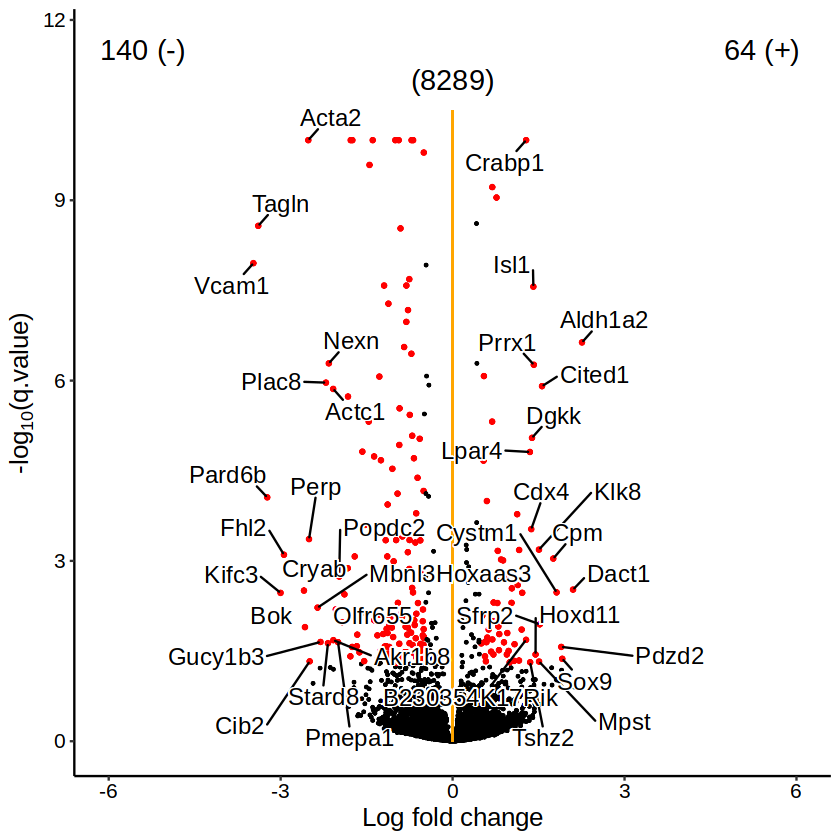

In [250]:
gg_volcano_plot(, xlim=6, ylim=10)

In [251]:
unique(da_results$celltype_updated)

[1] "Spinal_cord"                  "Rostral_neurectoderm"        
 [3] "Surface_ectoderm"             "Erythroid"                   
 [5] "Gut"                          "Blood_progenitors_1"         
 [7] "NMP"                          "Intermediate_mesoderm"       
 [9] "Allantois"                    "Caudal_epiblast"             
[11] "Forebrain_Midbrain_Hindbrain" "Mesenchyme"                  
[13] "Lateral_plate_mesoderm"       "Embryo_proper_endothelium"   
[15] "Neural_crest"                 "Somitic_mesoderm"            
[17] "Cardiomyocytes"               "Venous_endothelium"          
[19] "Allantois_endothelium"        "Paraxial_mesoderm"           
[21] "YS_mesothelium"               "Pharyngeal_mesoderm"         
[23] "Amniotic_ectoderm"            "Blood_progenitors_2"         
[25] "Mixed"                        "PGC"                         
[27] "Caudal_Mesoderm"              "Def._endoderm"               
[29] "Notochord"                    "Caudal_neurectoderm"         
[31] "YS_endothelium"

In [257]:
Milo_sce = readRDS(file.path(args$outdir, 'Milo_sce.rds'))
da_results = fread(file.path(args$outdir, 'da_results.txt.gz'))

In [258]:
da_results$NhoodGroup <- ifelse(da_results$celltype_updated != 'Lateral_plate_mesoderm', 'Other', 
                                ifelse(da_results$logFC > 2, 'Up', 'Not_Up'))
#da_nhood_markers <- findNhoodGroupMarkers(embryo_milo, da_results, subset.row = rownames(embryo_milo)[1:10])

In [259]:
da_allantois = da_results[celltype_updated == 'Lateral_plate_mesoderm']
#Milo_allantois =  Milo_sce[,Milo_sce$tdTom==FALSE]

In [260]:
test = lapply(c('Up', 'Not_Up'),function(x){
    tmp = nhoods(Milo_sce)[Milo_sce$tdTom==FALSE,]
    cells = tmp[,da_allantois[da_allantois$NhoodGroup == x, Nhood]]
    cell_sums = rowSums(cells)
    cells_keep = rep(rownames(cells), cell_sums)
})
names(test) = c('Up', 'Not_Up')

In [262]:
allantois_up = Milo_sce[,test[['Up']]]
allantois_up$group = 'Up'

allantois_down = Milo_sce[,test[['Not_Up']]]
allantois_down$group = 'Not_Up'

In [263]:
allantois_sce = cbind(allantois_up, allantois_down)

In [264]:
# Pseudobulk by sample and variable
summed <- aggregateAcrossCells(allantois_sce, 
    id=colData(allantois_sce)[,c("group", "sample")])

summed.filt <- summed[,summed$ncells >= 20]

In [265]:
keep <- filterByExpr(summed.filt)
summed.filt <- summed.filt[keep,]

In [266]:
summed.filt <- calcNormFactors(summed.filt)

In [267]:
design <- model.matrix(~factor(sample) + factor(group), summed.filt$samples)

In [268]:
summed.filt <- estimateDisp(summed.filt, design)


In [269]:
fit <- glmQLFit(summed.filt, design, robust=TRUE)

In [274]:
res = glmTreat(fit, coef = ncol(fit$design), contrast = NULL, lfc = 0.5,
         null = "interval")

In [277]:
res <- glmQLFTest(fit, coef=ncol(design))

In [278]:
de.results = as.data.table(topTags(res, n=nrow(summed.filt))$table, keep.rownames=T) %>% setnames('rn', 'gene') %>% 
    .[,sig:=ifelse(abs(logFC)>=0.5 & FDR<=0.05, TRUE, FALSE)] %>%  # significance
        .[!is.na(logFC),] %>%
        setnames('FDR', 'padj_fdr')

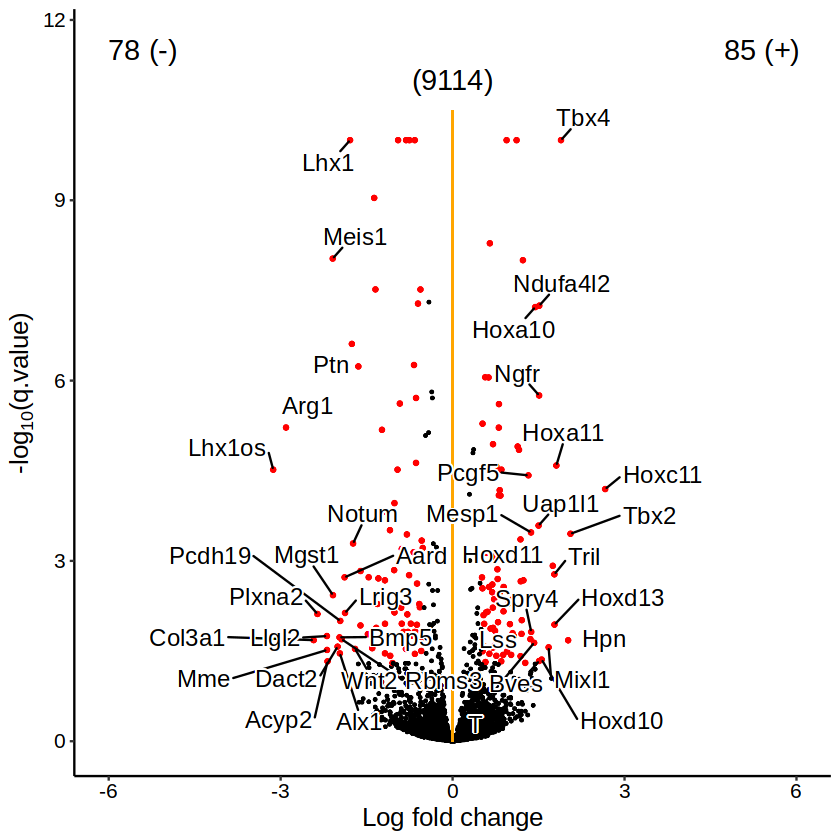

In [279]:
gg_volcano_plot(, xlim=6, ylim=10)

In [280]:
da_results$NhoodGroup <- ifelse(da_results$celltype_updated != 'Intermediate_mesoderm', 'Other', 
                                ifelse(da_results$logFC > 2, 'Up', 'Not_Up'))
#da_nhood_markers <- findNhoodGroupMarkers(embryo_milo, da_results, subset.row = rownames(embryo_milo)[1:10])

In [281]:
da_allantois = da_results[celltype_updated == 'Intermediate_mesoderm']
#Milo_allantois =  Milo_sce[,Milo_sce$tdTom==FALSE]

In [282]:
test = lapply(c('Up', 'Not_Up'),function(x){
    tmp = nhoods(Milo_sce)[Milo_sce$tdTom==FALSE,]
    cells = tmp[,da_allantois[da_allantois$NhoodGroup == x, Nhood]]
    cell_sums = rowSums(cells)
    cells_keep = rep(rownames(cells), cell_sums)
})
names(test) = c('Up', 'Not_Up')

In [283]:
allantois_up = Milo_sce[,test[['Up']]]
allantois_up$group = 'Up'

allantois_down = Milo_sce[,test[['Not_Up']]]
allantois_down$group = 'Not_Up'

In [284]:
allantois_sce = cbind(allantois_up, allantois_down)

In [285]:
# Pseudobulk by sample and variable
summed <- aggregateAcrossCells(allantois_sce, 
    id=colData(allantois_sce)[,c("group", "sample")])

summed.filt <- summed[,summed$ncells >= 20]

In [286]:
keep <- filterByExpr(summed.filt)
summed.filt <- summed.filt[keep,]

In [287]:
summed.filt <- calcNormFactors(summed.filt)

In [288]:
design <- model.matrix(~factor(sample) + factor(group), summed.filt$samples)

In [289]:
summed.filt <- estimateDisp(summed.filt, design)


In [290]:
fit <- glmQLFit(summed.filt, design, robust=TRUE)

In [295]:
res = glmTreat(fit, coef = ncol(fit$design), contrast = NULL, lfc = 0.5,
         null = "interval")

In [298]:
res <- glmQLFTest(fit, coef=ncol(design)) # Maybe not best to use

In [299]:
de.results = as.data.table(topTags(res, n=nrow(summed.filt))$table, keep.rownames=T) %>% setnames('rn', 'gene') %>% 
    .[,sig:=ifelse(abs(logFC)>=0.5 & FDR<=0.05, TRUE, FALSE)] %>%  # significance
        .[!is.na(logFC),] %>%
        setnames('FDR', 'padj_fdr')

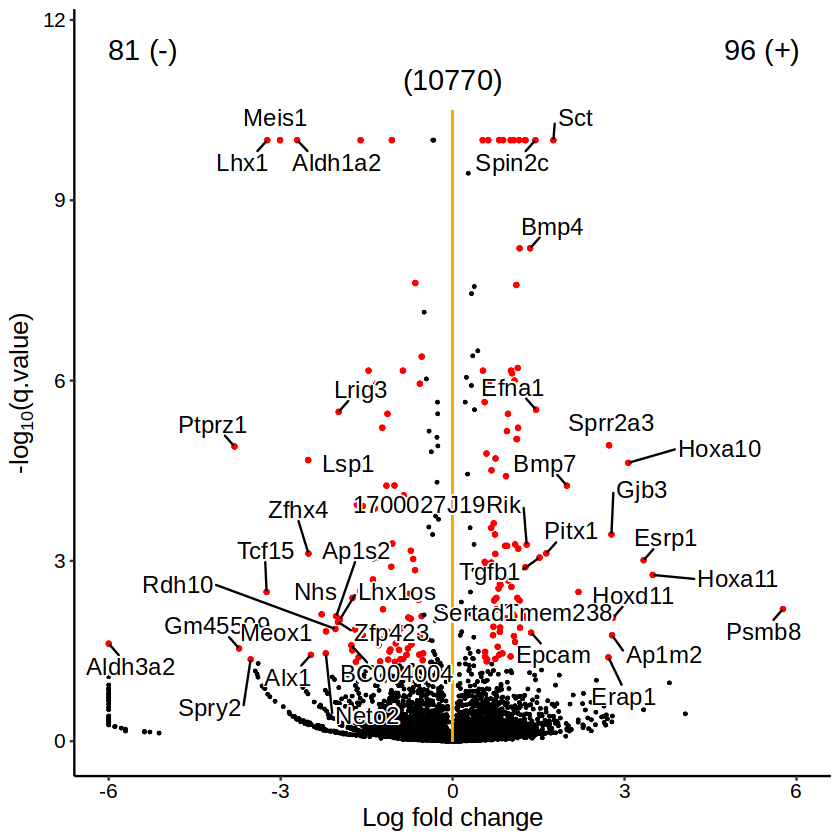

In [300]:
gg_volcano_plot(, xlim=6, ylim=10)

In [301]:
Milo_sce = readRDS(file.path(args$outdir, 'Milo_sce.rds'))
da_results = fread(file.path(args$outdir, 'da_results.txt.gz'))

In [315]:
gene_metadata <- fread(io$gene_metadata) %>% .[,c("chr","ens_id","symbol")] %>%
  .[symbol!="" & ens_id%in%rownames(Milo_sce)] %>%
  .[!duplicated(symbol)]
# Imprinted genes
imprint = gene_metadata[c(grep('maternally', gene_metadata$description),
                       grep('paternally', gene_metadata$description)), symbol]
genes.intersect <- rownames(Milo_sce)
# Filter some genes manually
genes.intersect <- genes.intersect[grep("^Rik|Rik$|^mt-|^Rps|^Rpl|^Gm",genes.intersect,invert=T)] # filter out non-informative genes
genes.intersect <- genes.intersect[grep("^Hbb|^Hba",genes.intersect,invert=T)] # test removing Haem genes 
genes.intersect <- genes.intersect[!genes.intersect %in% c(imprint, 'Grb10', 'Nnat')] # remove imprinted genes
genes.intersect <- genes.intersect[!genes.intersect %in% c("Xist", "Tsix")] # remove Xist & Tsix
genes.intersect <- genes.intersect[!genes.intersect=="tomato-td"] # remove tomato itself
genes.intersect <- genes.intersect[!genes.intersect %in% gene_metadata[chr=="chrY",symbol]] # no genes on y-chr 

In [318]:
Milo_sce = Milo_sce[genes.intersect,]

In [347]:
da_results$NhoodGroup <- ifelse(da_results$celltype_updated != 'Allantois', 'Other', 'Celltype')
#da_nhood_markers <- findNhoodGroupMarkers(embryo_milo, da_results, subset.row = rownames(embryo_milo)[1:10])

In [348]:
dge <- testDiffExp(Milo_sce, da_results, design = ~ factor(pool) + factor(tdTom), meta.data = data.frame(colData(Milo_sce)),
                     subset.row = rownames(Milo_sce), subset.nhoods=da_results$NhoodGroup!="Other")

Warning message:
“Zero sample variances detected, have been offset away from zero”


In [349]:
res = as.data.table(dge$Celltype, keep.rownames=T)[order(logFC)]

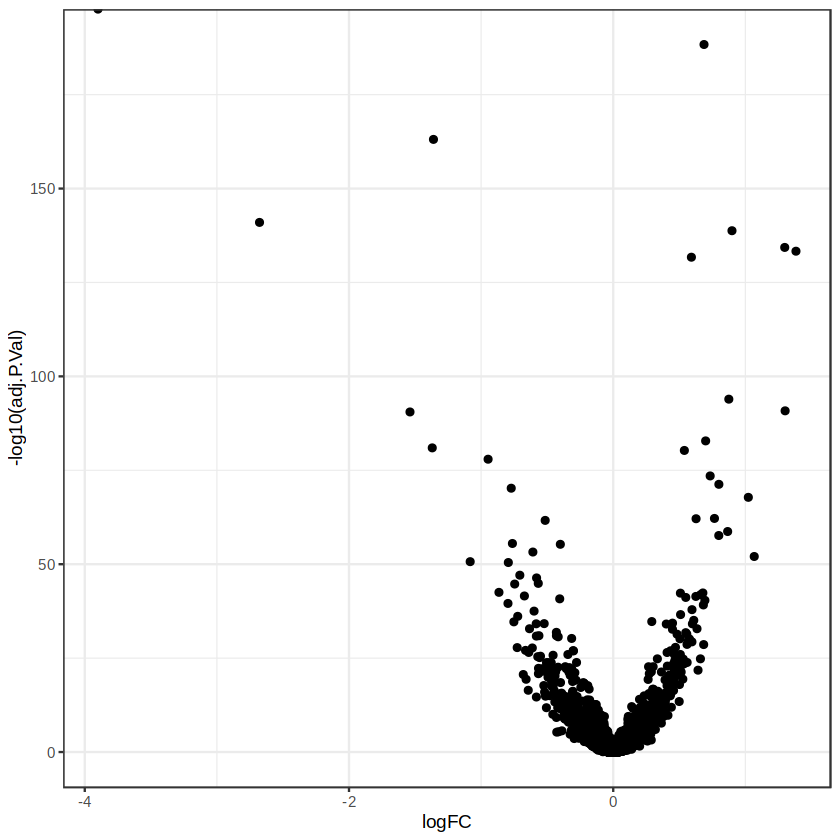

In [350]:
ggplot(res, aes(logFC, -log10(adj.P.Val))) + 
    geom_point() + theme_bw()

### Endothelial subsets only

In [216]:
args$features = 2000
args$npcs = 10
args$n_neighbors = 10
args$min_dist = 0.5
args$prop = 0.1

In [217]:
###############
## Load data ##
###############

# Load metadata
sample_metadata = fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_call==FALSE] %>%
   .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)] %>% 
   .[celltype_updated %in% c(    
                            'Venous_endothelium', 
                            'Embryo_proper_endothelium', 
                            'Allantois_endothelium', 
                            'YS_endothelium')]


# Load RNA expression data as SingleCellExperiment object
sce <- load_SingleCellExperiment(args$sce, cells=sample_metadata$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce) <- sample_metadata %>% tibble::column_to_rownames("cell") %>% DataFrame

In [218]:
##############################
## Dimensionality Reduction ##
##############################

if (args$batch_correction %in% c('tdTom')) {
     source(here::here("mapping/run/mnn/mapping_functions.R"))
     library(batchelor)
   }

 if (length(args$vars_to_regress)>0) {
  stopifnot(args$vars_to_regress%in%colnames(sample_metadata))
 }

## Feature selection 

# Find HVGs - detection on WT samples only
# Get gene metadata
gene_metadata <- fread(io$gene_metadata) %>% .[,c("chr","ens_id","symbol", "description")] %>%
  .[symbol!="" & ens_id%in%rownames(sce)] %>%
  .[!duplicated(symbol)]

# Imprinted genes
imprint = gene_metadata[c(grep('maternally', gene_metadata$description),
                       grep('paternally', gene_metadata$description)), symbol]
# Other imprinted genes: 
#- Nnat (https://www.genecards.org/cgi-bin/carddisp.pl?gene=NNAT)
#- Grb10 (https://www.genecards.org/cgi-bin/carddisp.pl?gene=GRB10)

genes_keep = rownames(sce)
genes_keep <- genes_keep[grep("^Rik|Rik$|^mt-|^Rps|^Rpl|^Gm",genes_keep,invert=T)] # filter out non-informative genes
genes_keep <- genes_keep[grep("^Hbb|^Hba",genes_keep,invert=T)] # test removing Haem genes 
genes_keep <- genes_keep[!genes_keep %in% c(imprint, 'Grb10', 'Nnat')] # remove imprinted genes
genes_keep <- genes_keep[!genes_keep %in% c("Xist", "Tsix")] # remove Xist & Tsix
genes_keep <- genes_keep[!genes_keep == "tomato-td"] # remove tomato itself
genes_keep <- genes_keep[!genes_keep %in% gene_metadata[chr=="chrY",symbol]] # no genes on y-chr 

sce_wt = sce[genes_keep, sample_metadata[tdTom==FALSE, cell]]
# Find variable genes using Seurat
hvgs = VariableFeatures(FindVariableFeatures(as.Seurat(sce_wt), nfeatures = args$features))

sce_filt <- sce[hvgs,]

In [219]:
## Regress out covariates 
 if (length(args$vars_to_regress)>0) {
   print(sprintf("Regressing out variables: %s", paste(args$vars_to_regress,collapse=" ")))
   logcounts(sce_filt) <- RegressOutMatrix(
     mtx = logcounts(sce_filt), 
     covariates = colData(sce_filt)[,args$vars_to_regress,drop=F]
   )
 }

[1] "Regressing out variables: nFeature_RNA nCount_RNA mitochondrial_percent_RNA ribosomal_percent_RNA"


In [220]:
# PCA and batch correction
if (args$batch_correction=='tdTom') {
    print('batch correcting by tdTom')
    pca <- multiBatchPCA(sce_filt, batch = colData(sce_filt)[[args$batch_correction]], d = args$npcs)
    pca.corrected <- reducedMNN(pca)$corrected
    colnames(pca.corrected) <- paste0("PC",1:ncol(pca.corrected))
    pca.corrected = pca.corrected[match(colnames(sce_filt), rownames(pca.corrected)),]
    reducedDim(sce_filt, "PCA") <- pca.corrected
 } else {
    print('PCA without batch correction')
    sce_filt <- runPCA(sce_filt, ncomponents = args$npcs, ntop=args$features)  
 }

[1] "batch correcting by tdTom"


In [221]:
 pca.dt <- reducedDim(sce_filt,"PCA") %>% round(3) %>% as.data.table(keep.rownames = T) %>% setnames("rn","cell")


In [222]:
## UMAP
set.seed(args$seed)
sce_filt <- runUMAP(sce_filt, dimred="PCA", n_neighbors = args$n_neighbors, min_dist = args$min_dist)

# Fetch UMAP coordinates
umap.dt <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
  .[,cell:=colnames(sce_filt)] %>%
  setnames(c("UMAP1","UMAP2","cell"))

In [223]:
# plotting
to.plot <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
    .[,cell:=colnames(sce_filt)] %>%
    merge(sample_metadata, by="cell")

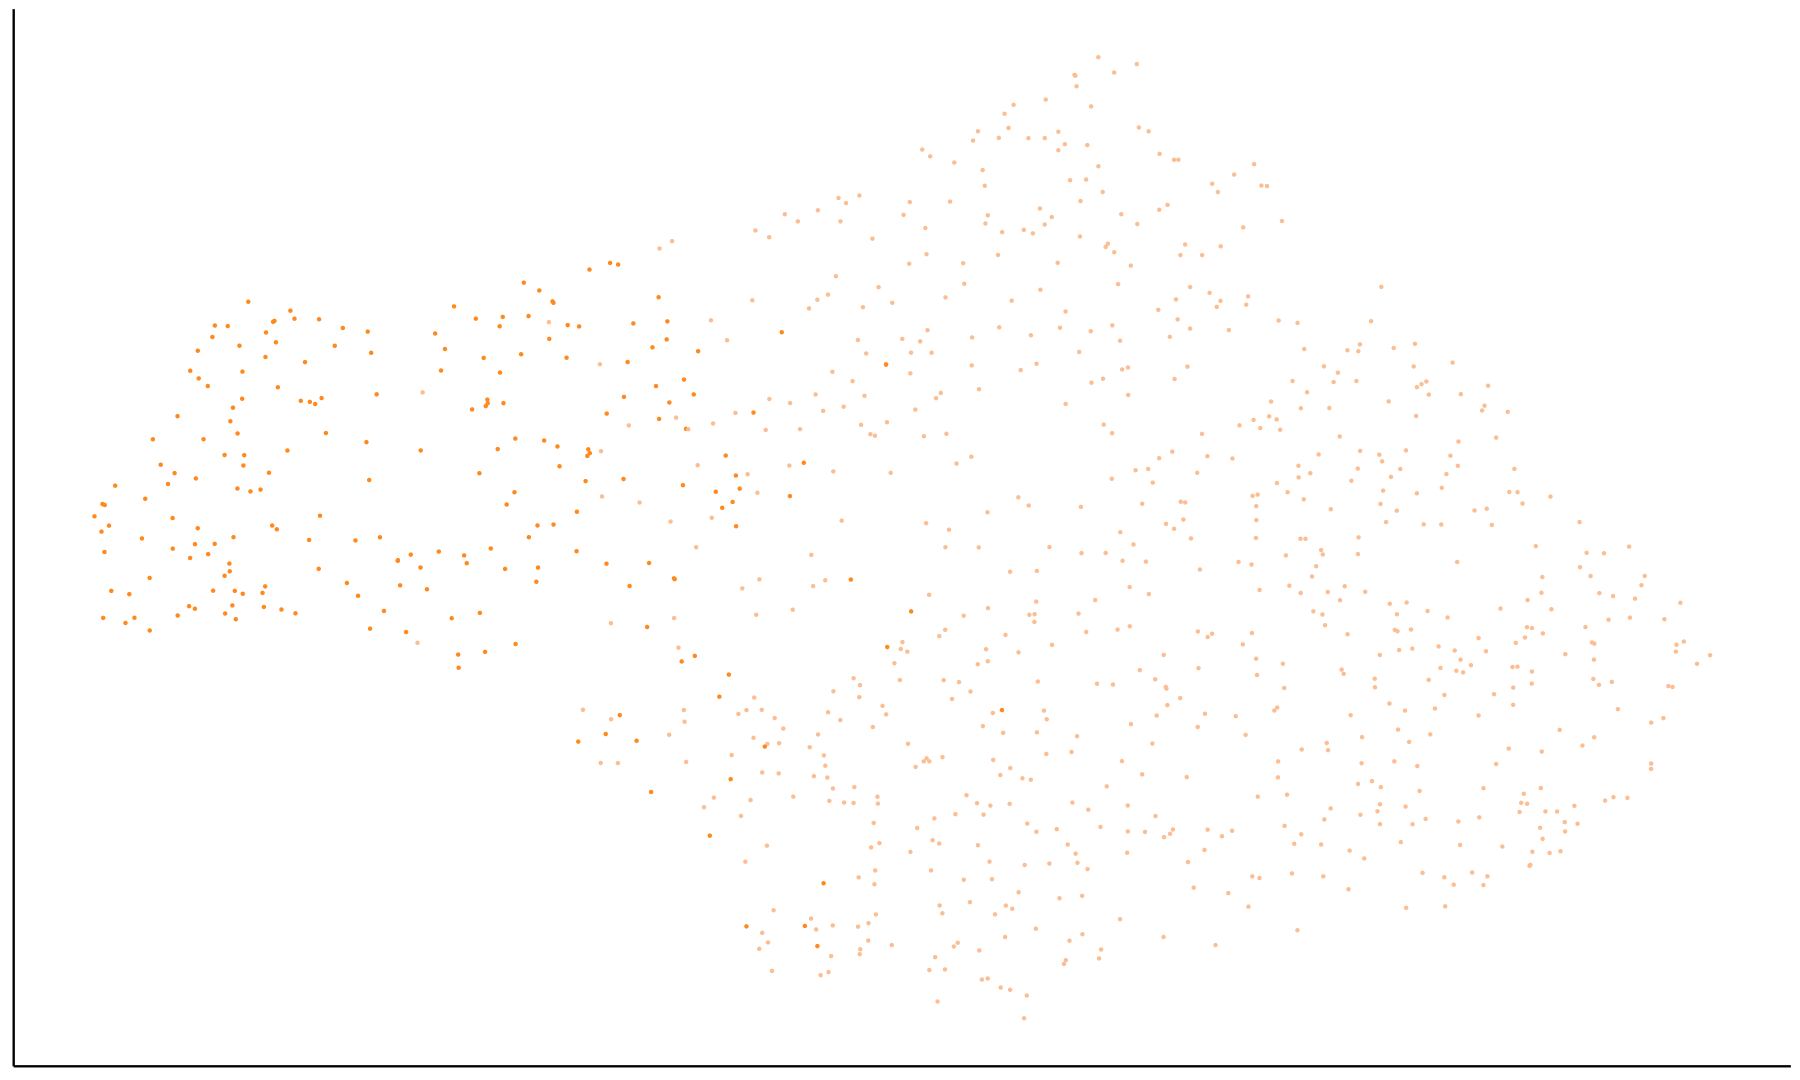

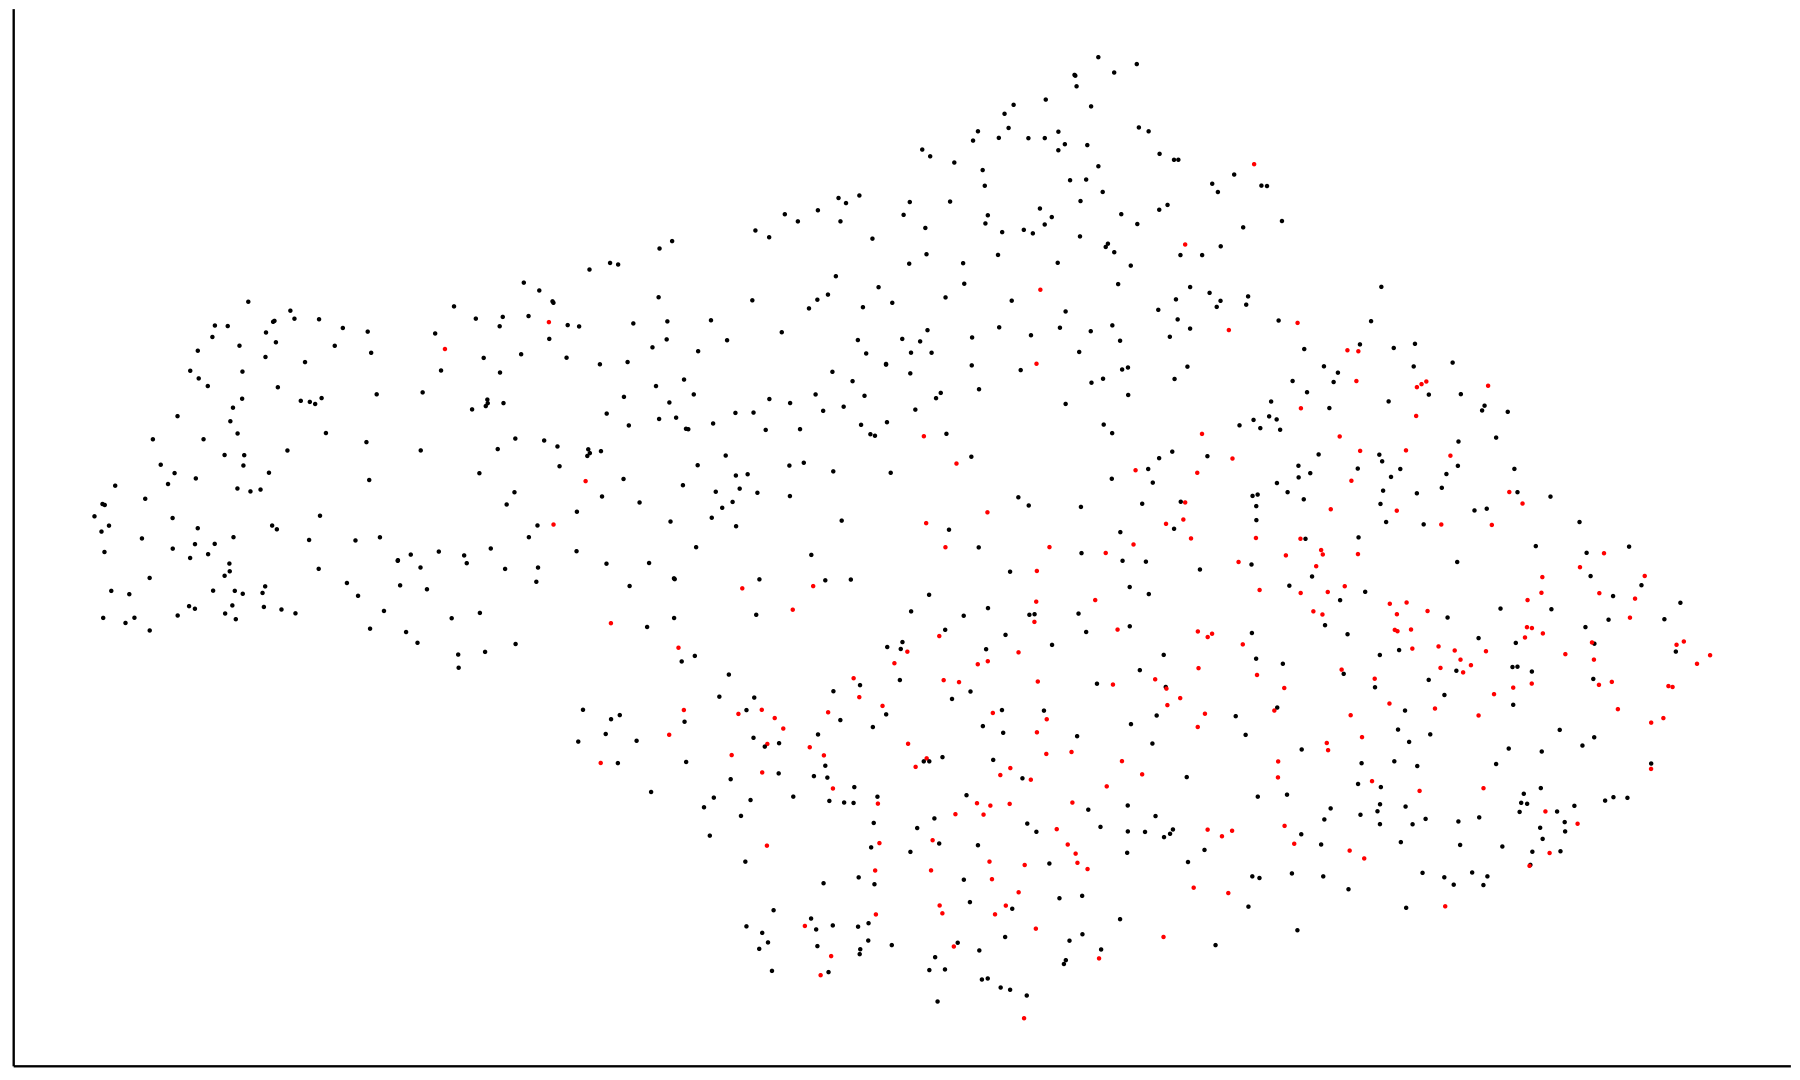

In [224]:
ggplot(to.plot, aes_string(x="V1", y="V2", col='celltype.mapped_mnn')) +
    geom_point(size=0.2) +
    theme_classic() +
    scale_color_manual(values=opts$celltype.colors) +
    theme(
        legend.position="none",
        legend.title=element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    )

ggplot(to.plot, aes_string(x="V1", y="V2", col='tdTom')) +
    geom_point(size=0.2) +
    theme_classic() +
    scale_color_manual(values=opts$tdTom.color) +
    theme(
        legend.position="none",
        legend.title=element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    )

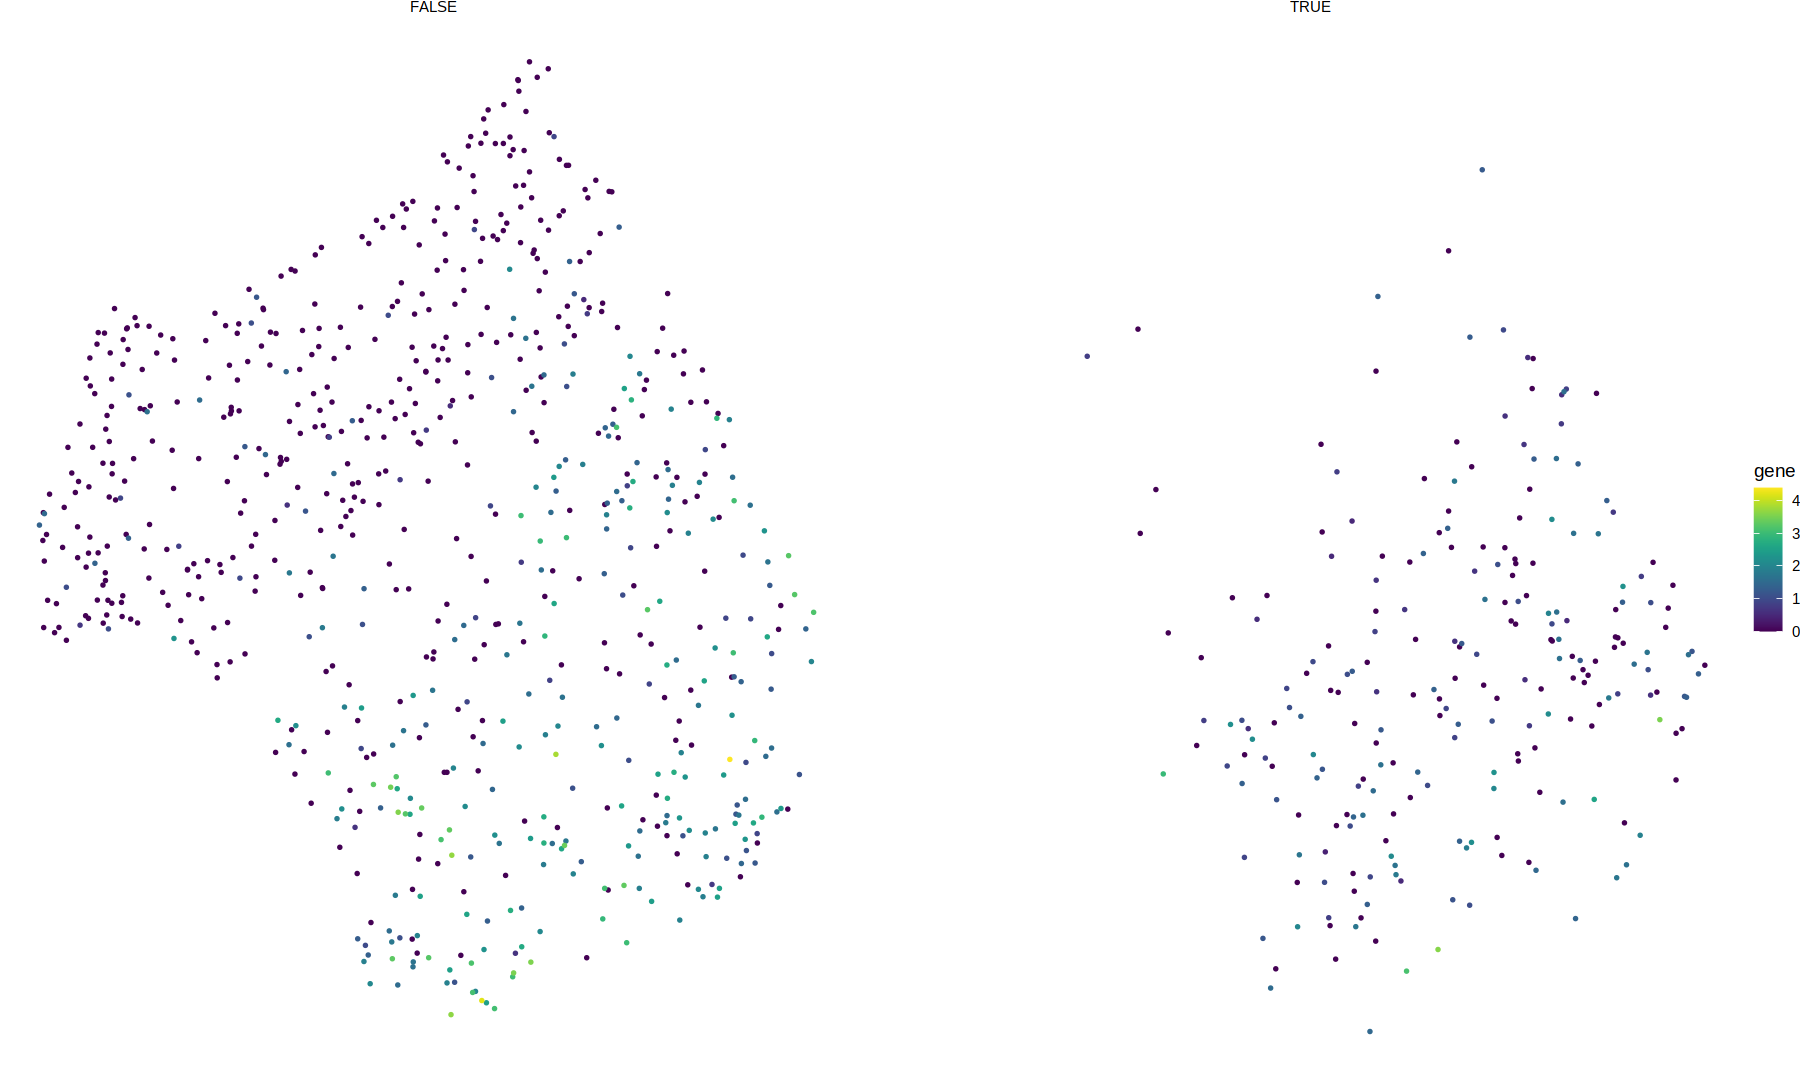

In [225]:
test = to.plot %>% copy() %>% .[,gene:=as.vector(logcounts(sce['Dlk1',to.plot$cell]))]  %>% .[order(gene)]
options(repr.plot.width=15)
ggplot(test, aes(V1, V2, color = gene)) + 
       geom_point(size=0.5) + 
       viridis::scale_color_viridis() + 
        facet_wrap(~tdTom) + 
        theme_void()

#### MiloR

In [226]:
# Add PCA to SCE object
reducedDim(sce,"PCA") = reducedDim(sce_filt,"PCA")

# Add UMAP to SCE object
reducedDim(sce,"UMAP") = reducedDim(sce_filt,"UMAP")

# Add UMAP of Atlas to SCE object
umap.dt <- sample_metadata %>%
    .[,c("cell","umapX","umapY")]
umap = umap.dt[match(colnames(sce), cell)] %>% tibble::column_to_rownames("cell") %>% as.matrix
reducedDim(sce,"UMAP_atlas") = umap

In [227]:
Milo_sce

class: Milo 
dim: 29453 957 
metadata(0):
assays(2): counts logcounts
rownames(29453): Xkr4 Gm1992 ... CAAA01147332.1 tomato-td
rowData names(0):
colnames(957): SLX-20795_SITTG11_HKTG2DRXY#AGAGCCCTCTCCATAT-1
  SLX-20795_SITTF11_HKTG2DRXY#TGTTCCGGTCGTTTCC-1 ...
  SLX-20795_SITTB11_HKTG2DRXY#TAAGCGTCATTGAGCT-1
  SLX-20795_SITTG11_HKTG2DRXY#TGAGCATCACGGTGAA-1
colData names(25): closest.cell_mnn sample ... pool sample_ko
reducedDimNames(3): PCA UMAP UMAP_atlas
mainExpName: RNA
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1

In [308]:
args$prop = 0.05
args$n_neighbors = 25

In [309]:
# create object
Milo_sce <- Milo(sce)

colData(Milo_sce)$sample_ko = paste0(colData(Milo_sce)$sample, '_',  colData(Milo_sce)$tdTom)

# Build graph
Milo_sce <- buildGraph(Milo_sce, 
                       k = args$n_neighbors, 
                       d = args$npcs, 
                       reduced.dim = "PCA")

# Identify neighbourhoods from NN-cells
# lower prop for larger datasets
Milo_sce <- makeNhoods(Milo_sce, 
                       prop = args$prop, 
                       k = args$n_neighbors, 
                       d = args$npcs, 
                       refined = TRUE, 
                       reduced_dims = "PCA")


# count cells of different samples per neighbourhood
Milo_sce <- countCells(Milo_sce, meta.data = as.data.frame(colData(Milo_sce)), sample="sample_ko")

# Calculate Neighbourhood Distances (most time consuming step)
Milo_sce <- calcNhoodDistance(Milo_sce, d=args$npcs, reduced.dim = "PCA")

# Build neighbourhood graph
Milo_sce <- buildNhoodGraph(Milo_sce)

Constructing kNN graph with k:25

Checking valid object

Running refined sampling with reduced_dim

Checking meta.data validity

Counting cells in neighbourhoods



In [310]:
Milo_sce

class: Milo 
dim: 29453 957 
metadata(0):
assays(2): counts logcounts
rownames(29453): Xkr4 Gm1992 ... CAAA01147332.1 tomato-td
rowData names(0):
colnames(957): SLX-20795_SITTG11_HKTG2DRXY#AGAGCCCTCTCCATAT-1
  SLX-20795_SITTF11_HKTG2DRXY#TGTTCCGGTCGTTTCC-1 ...
  SLX-20795_SITTB11_HKTG2DRXY#TAAGCGTCATTGAGCT-1
  SLX-20795_SITTG11_HKTG2DRXY#TGAGCATCACGGTGAA-1
colData names(25): closest.cell_mnn sample ... pool sample_ko
reducedDimNames(3): PCA UMAP UMAP_atlas
mainExpName: RNA
altExpNames(0):
nhoods dimensions(2): 957 45
nhoodCounts dimensions(2): 45 8
nhoodDistances dimension(1): 45
graph names(1): graph
nhoodIndex names(1): 45
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 45 45

In [311]:
# Embryo design table
embryo_design <- data.frame(colData(Milo_sce))[,c("sample_ko", "sample", 'tdTom', 'pool')]

embryo_design <- distinct(embryo_design)
rownames(embryo_design) <- embryo_design$sample_ko

# Test differential abundance per hood
da_results <- testNhoods(Milo_sce, design = ~ as.factor(pool) + tdTom, design.df = embryo_design, reduced.dim="PCA")

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [312]:
p1 = ggplot(da_results, aes(PValue)) + 
    geom_histogram(bins=50) + 
    theme_bw()

p2 = ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
    geom_point() +
    geom_hline(yintercept = 1) + ## Mark significance threshold (10% FDR)
    theme_bw()


## Plot single-cell UMAP
p3 = plotReducedDim(Milo_sce, dimred = "UMAP", colour_by="tdTom_corr", text_by = "celltype_updated", 
                          text_size = 3, point_size=0.3, text_colour = "grey30") +
    scale_color_manual(values=opts$tdTom.color, name = 'tdTom') + 
    theme_void() + 
    theme(legend.position='right') +
    guides(fill="none")

## Plot neighbourhood graph
p4 = plotNhoodGraphDA(Milo_sce, da_results, layout="UMAP",alpha=0.05) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


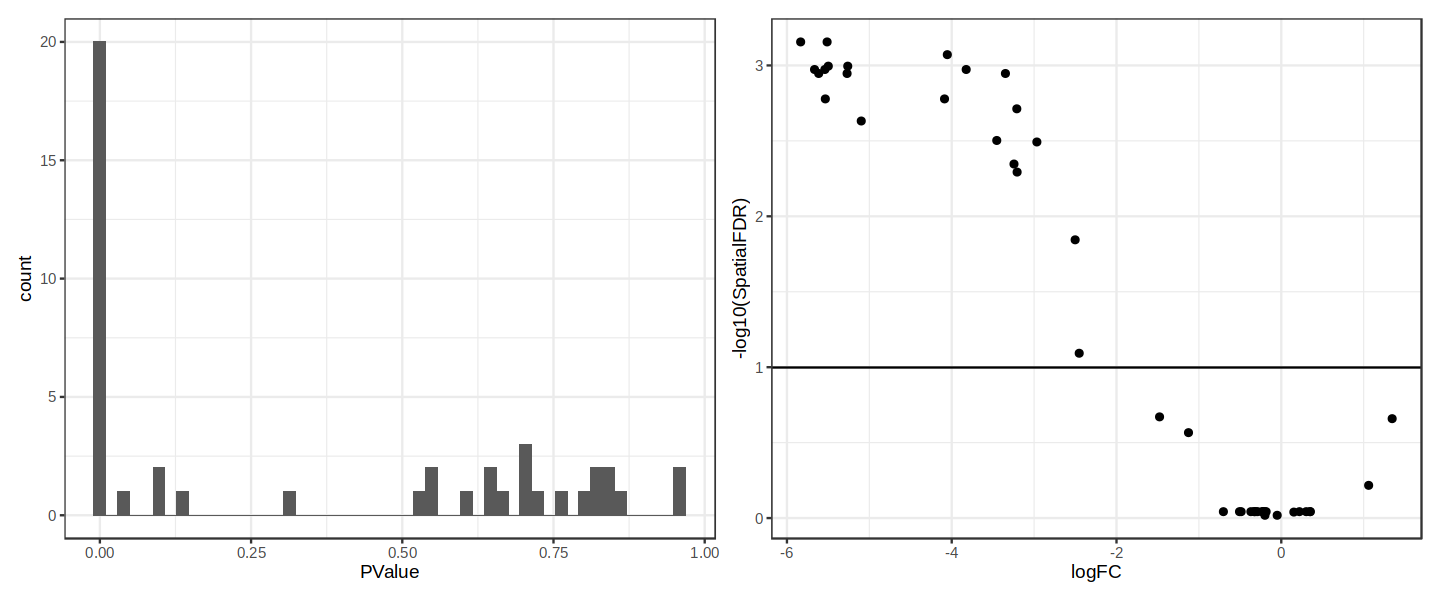

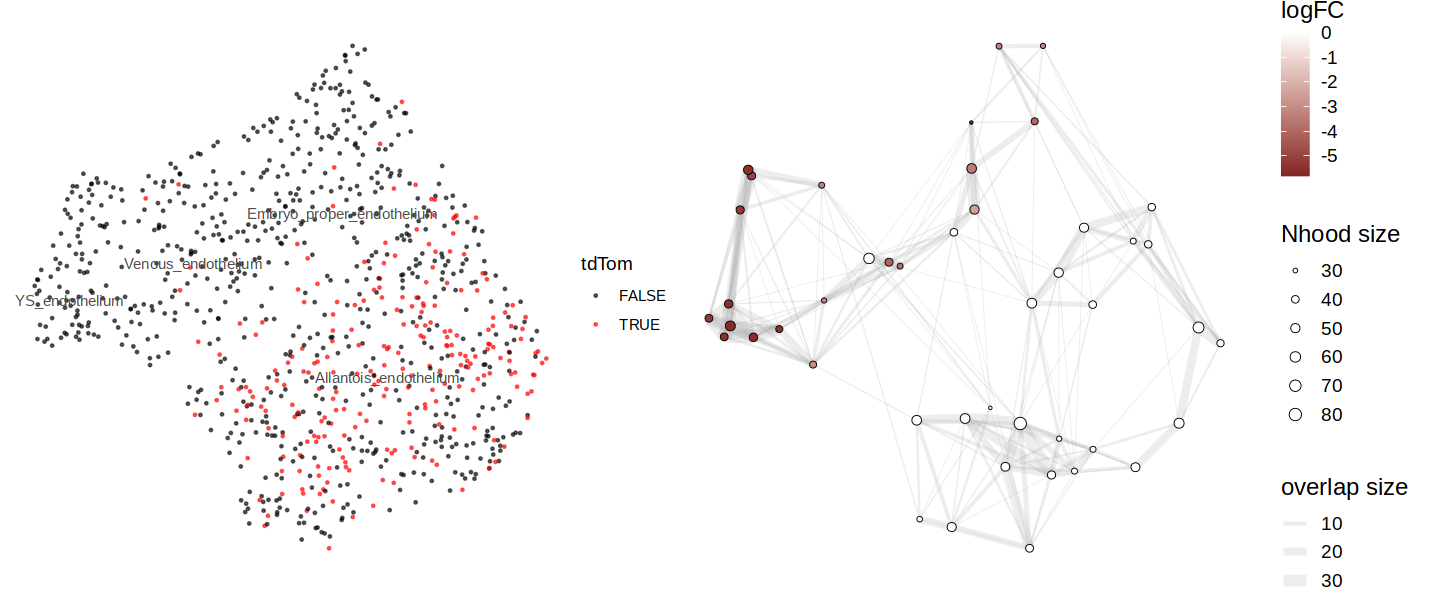

In [313]:
options(repr.plot.width = 12, repr.plot.height=5)

p1 + p2
    p3 + p4 

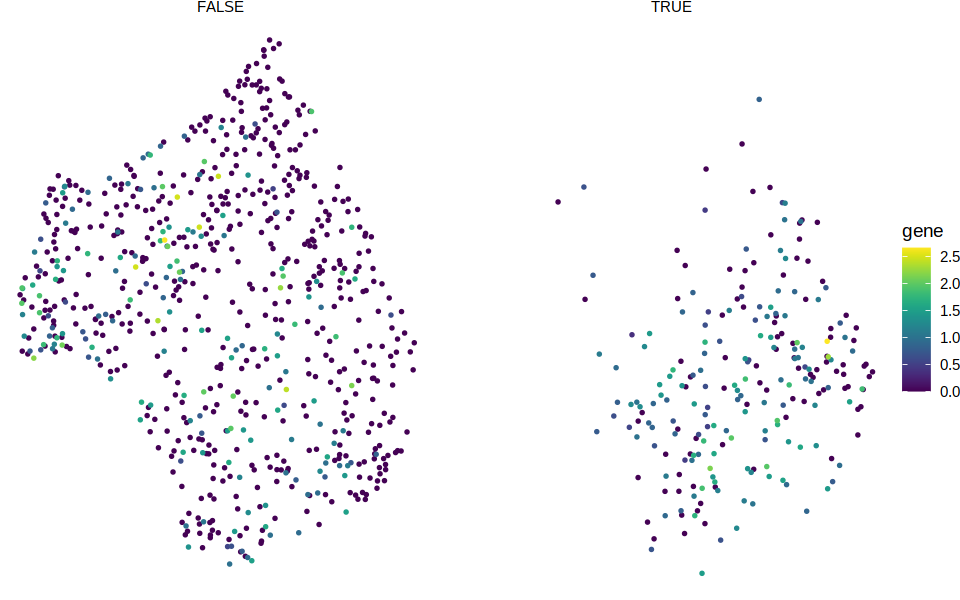

In [320]:
test = to.plot %>% copy() %>% .[,gene:=as.vector(logcounts(sce['Sox18',to.plot$cell]))]  %>% .[order(gene)]
options(repr.plot.width=8, repr.plot.height=5)
ggplot(test, aes(V1, V2, color = gene)) + 
       geom_point(size=0.5) + 
       viridis::scale_color_viridis() + 
        facet_wrap(~tdTom) + 
        theme_void()

In [315]:
# Find Neighbourhood groups
da_results <- groupNhoods(Milo_sce, da_results, max.lfc.delta = 0.5, overlap = 20)

# Annotate hoods by celltype
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype.mapped_mnn")
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype_extended.mapped_mnn")
da_results <- annotateNhoods(Milo_sce, da_results, coldata_col = "celltype_updated")

# Annotate 'mixed' hoods when there is not one main celltype
da_results$celltype.mapped_mnn <- ifelse(da_results$celltype.mapped_mnn_fraction < 0.4, "Mixed", da_results$celltype.mapped_mnn)
da_results$celltype_extended.mapped_mnn <- ifelse(da_results$celltype.mapped_mnn_fraction < 0.4, "Mixed", da_results$celltype_extended.mapped_mnn)
da_results$celltype_updated <- ifelse(da_results$celltype_updated_fraction < 0.4, "Mixed", da_results$celltype_updated)

Found 21 DA neighbourhoods at FDR 10%

nhoodAdjacency found - using for nhood grouping

Converting celltype.mapped_mnn to factor...

Converting celltype_extended.mapped_mnn to factor...

Converting celltype_updated to factor...



In [316]:
da_results.plot = as.data.table(da_results) %>% copy() %>%
    .[,color := ifelse(SpatialFDR < 5e-2, logFC, 0)] %>% .[order(abs(color))] %>% 
    .[,germ_layer := str_to_title(celltype2germlayer[celltype_updated])] %>%
    .[, celltype_updated := factor(celltype_updated, levels = names(celltype2germlayer))]

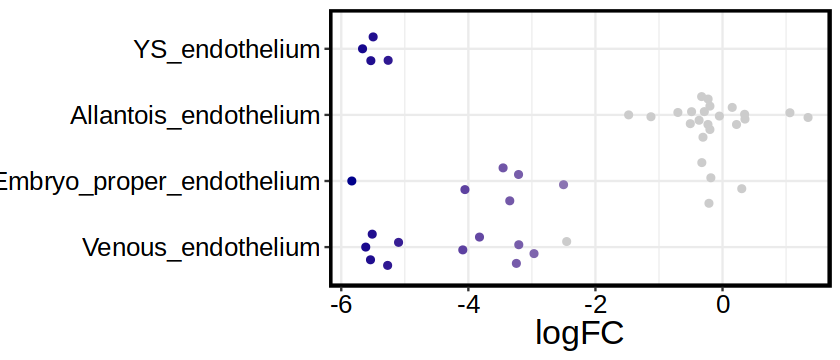

In [318]:
options(repr.plot.width = 7, repr.plot.height=3)
ggplot(da_results.plot, aes(logFC, celltype_updated, color=color)) + 
    ggbeeswarm::geom_quasirandom() + 
    scale_color_gradient2(low='darkblue', mid='grey80', high='darkred') + 
    facet_grid(rows = vars(germ_layer), scales='free', space='free') + 
    theme_bw() + 
    theme(axis.text = element_text(size=15, color='black'),
          axis.title.y = element_blank(),
          axis.title.x = element_text(size=20, color='black'),
          panel.border = element_rect(color='black', linewidth=1.3),
          legend.position='none',
          strip.background=element_blank(),
          strip.text.y = element_blank()) #_text(size=15, color='black', angle=0, hjust=0))